# Brain tumor segmentation using U-Net

![picture](https://drive.google.com/uc?export=view&id=13_q2KyrP1eDIm0CsNlsvx1-vLuhH3BKX)

## Bevezetés
Az elmúlt néhány évben a **számítógépes látás** területe jelentős növekedésen ment keresztül. A digitális képek felvételére, feldolgozására, elemzésére és megértésére szolgáló módszerek széles körét foglalja magában.

E módszerek közül az egyiket **képszegmentálásnak** nevezik.

### Mi a képszegmentálás?
A képszegmentálás egy olyan technika, amellyel **egy képet több szegmensre vagy régióra** lehet szétválasztani, amelyek mindegyike a kép egy-egy különböző objektumának vagy részének felel meg.

A cél a kép egyszerűsítése és könnyebb elemezhetővé tétele, hogy a számítógép jobban megértse és értelmezze a kép tartalmát, ami nagyon hasznos lehet!

#### Alkalmazási területek

A képszegmentálásnak valóban számos alkalmazási területe van, mint például **tárgyak észlelése és felismerése, orvosi képalkotás és önvezető rendszerek**. Mindezekben az esetekben a kép tartalmának számítógép általi megértése alapvető fontosságú.

#### Példa
Egy utcaképen, amelyen autók láthatóak, a szegmentáló algoritmus képes lenne a képet különböző régiókra osztani: egy az autóknak, egy az útnak, egy az égboltnak, egy a fáknak és így tovább.

![picture](https://drive.google.com/uc?export=view&id=1Wy7jFDTFyKuo6sE4OKwLXSQ3VAF5kUxM)

### A szegmentáció különböző típusai

A képszegmentálásnak két fő típusa van: **szemantikus szegmentálás** és **instans szegmentálás**.

- A **szemantikus szegmentálás** az a feladat, hogy egy kép minden egyes pixeléhez osztálycímkét rendeljünk. Például egy városról készült képen a szemantikus szegmentálás feladata az lenne, hogy minden egyes képpontot egy bizonyos osztályba tartozónak címkézzünk, például "épület", "út", "égbolt", ....

- Az **Instance szegmentáció** a szemantikus szegmentáció egy olyan változata, amely nem csak osztálycímkét rendel minden egyes pixelhez, hanem különbséget tesz ugyanazon osztály több példánya között is egy képen belül. Például egy városról készült képen a feladat nem csak az lenne, hogy minden egyes képpontot egy bizonyos osztályba tartozónak címkézzünk, mint például "épület", "út", ..., hanem az is, hogy megkülönböztessük ugyanazon osztály különböző példányait, például a képen található különböző épületeket. Minden egyes épületet más-más színnel kell ábrázolni.

Természetesen lehetséges, hogy nem minden pixelhez rendelünk címkét. Valójában előfordulhat, hogy egyes képpontok a háttér részét képezik, vagy nem tartoznak a képen lévő érdekes objektumokhoz. Ezek a pixelek egy speciális osztályba sorolhatók, vagy címke nélkül hagyhatók.

## Felhasználási eset és célkitűzés

Ebben a bemutatóban az **orvosi képalkotás** érdekel minket. Célunk az lesz, hogy **az agydaganatokat a szegmentálásnak köszönhetően** felismerjük, minden egyes kép minden egyes pixelének osztályozásával.

Ehhez a fogjuk használni. [BraTS2020 dataset](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation). Ezt az adathalmazt a BraTS kihíváshoz használják, amely a *Multimodal Brain Tumor Image Segmentation* csoport által évente megrendezett kihívás, amelynek célja az agydaganatok szegmentálási teljesítményének **javítása**.

## Utasítások
Ezeket az utasításokat fogjuk követni:

- 1. lépés - A környezet beállítása
- 2. lépés - A BraTS2020 adatállomány letöltése
- 3. lépés - Az adatok feltárása
- 4. lépés - Az adatok előkészítése a képzéshez
- 5. lépés - A modell meghatározása
- 6. lépés - A modell képzése
- 7. lépés - Tumorszegmentációk előrejelzése
- 8. lépés - A modell kiértékelése

### 1. lépés - Környezet beállítása
Első lépésként állítsuk be a projektünk struktúráját. Számos könyvtárat kell telepítenünk.

In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import tensorflow as tf
import random
import gc
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

# kifejezetten a CNN részére
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, UpSampling2D

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math
tfkc = tfk.callbacks

### 2. lépés - A BraTS2020 adatállomány letöltése
Az adatkészlet letöltéséhez vagy követhetjük az adatkészlet [weboldalán](https://www.med.upenn.edu/cbica/brats2020/registration.html) feltüntetett lépéseket, vagy közvetlenül a [Kaggle](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation) oldalról hívhatjuk le az adatkészletet. Ebben a bemutatóban ezt a második megoldást fogjuk használni. Vagy közvetlenül a Kaggle weboldaláról tölthetjük le, vagy az API-jukon keresztül tölthetjük le.

*Az API használatát javaslom, ez lehetővé teszi, hogy az adatkészlet közvetlenül a notebook környezetében legyen.*

Az API használatához és a BraTS2020 adathalmaz letöltéséhez kattintson a profilképére a Kaggle-en, és lépjen a `Account` kategóriába. Görgessen lefelé, és kattintson az `Új API token létrehozása` gombra. Kapni fog egy `kaggle.json` fájlt, amely tartalmazza a hitelesítő adatokat. Importálja azt a notebook gyökerébe.

A Colab összekötése a Drive fiókkal:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Utvonal beállítása:

In [ ]:
path_to_zip_file = "/content/drive/My Drive/Colab Notebooks/BraTS2020 Dataset/brats20-dataset-training-validation.zip"

Az adatkészlet letöltésével egy zip-fájlt kapunk, amelynek neve `brats20-dataset-training-validation.zip`.

Most már csak ki kell csomagolnia a következő kóddal:

In [ ]:
# Unzip dataset
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

Mielőtt folytatnánk, ki kell javítanunk egy kis hibát az adatállományban. Az egyik fájlt ugyanis nem ugyanúgy nevezték el, mint a többit. A könnyebb feldolgozás érdekében átnevezzük, hogy ugyanaz a neve maradjon:

In [ ]:
# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

The file has been successfully renamed


### 3. lépés - Adatfeltárás
Most, hogy letöltöttük az adatállományt, próbáljuk meg felfedezni és megérteni azt!

A `brats20-dataset-training-validation` mappában két adathalmazt talál: egy Training és egy Validation mappát. Ha megnyitja a `BraTS2020_TrainingData` mappát, észreveheti, hogy tartalmaz egy másik mappát, amely 369 mintát tartalmaz (amelyek itt betegek).

#### Modalitások és szegmentálás

Minden minta tartalmazza:
- 4 különböző típusú mágneses rezonanciás képalkotó vizsgálatot ***(MRI)*** az agyukról, más néven ***modalitásokat***, amelyek neve ***T1***, ***T1ce***, ***T2*** és ***FLAIR***.
- Az agyuk tumoros és nem tumoros régióinak alapigazság szerinti szegmentálása, amelyet szakértők manuálisan végeztek el.

A jobb megértés érdekében jelenítsük meg ezeket a képeket:

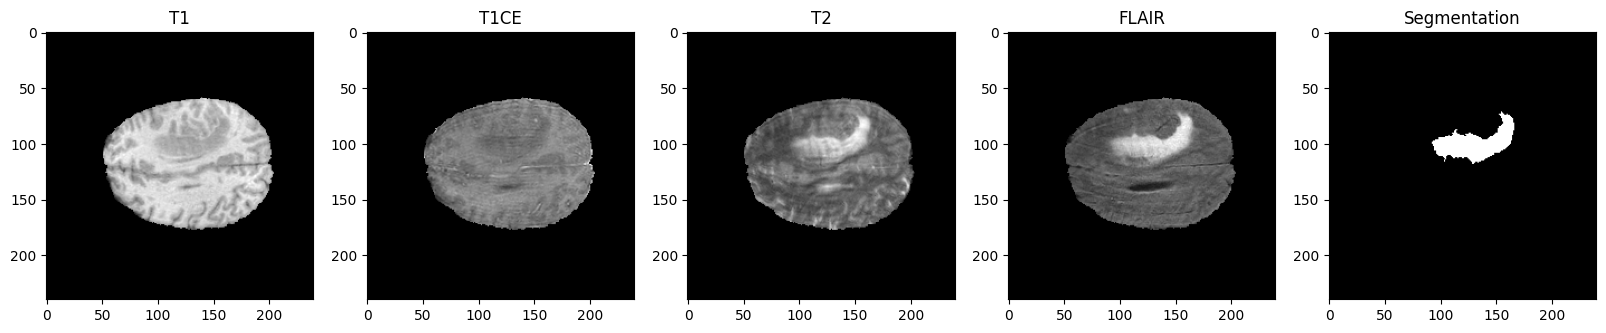

In [ ]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

Amint láthatod, a négy modalitás **különböző aspektusokat** hoz ki ugyanabból a képből.

Hogy pontosabbak legyünk, itt van az érdeklődésük leírása:
- **Natív T1 :** Az agyban található különböző típusú szövetek szerkezetének és összetételének bemutatására, valamint daganatok, ciszták és egyéb rendellenességek azonosítására szolgál.
- **Posztkontrasztos T1-súlyozott (T1ce, más néven T1Gd) :** Hasonló a T1-képekhez, de kontrasztanyag (gadolínium) beadásával, amely fokozza a rendellenességek láthatóságát.
- **T2-súlyozott (T2):** Az agy különböző típusú szöveteinek folyadéktartalmának kimutatására szolgál.
- **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery) :** E folyadéktartalom elnyomására használják. Ez hasznos lehet a T1 vagy T2 felvételeken nem jól látható elváltozások azonosítására, valamint az agy fehérállományában lévő elváltozások azonosítására, amelyek más típusú felvételeken nehezen láthatók.

Egy szakértő számára hasznos lehet ez a 4 módozat a daganat pontosabb elemzése és a tumor jelenlétének megerősítése érdekében.

A mi mesterséges megközelítésünk számára azonban **a négy helyett csak két modalitás használata** érdekes, mivel csökkentheti a szegmentálási feladat számítási és memóriaigényét, ezáltal gyorsabbá és hatékonyabbá téve azt. Ezért **kizárjuk a T1-et**, mivel rendelkezésünkre áll annak továbbfejlesztett változata, a T1ce. A T2 modalitást** szintén **nem vesszük figyelembe. A benne lévő folyadékok ugyanis ronthatják az előrejelzéseinket. Ezeket a folyadékokat eltávolítjuk a flair változatban, amely sokkal jobban kiemeli az érintett régiókat, és ezért sokkal érdekesebb lesz a képzésünk szempontjából.

#### Képek formátuma

Talán észrevetted, hogy ezek a képek `.nii` formátumúak. Ezek a szkennelések valóban NIfTI fájlok (*Neuroimaging Informatics Technology Initiative*). A NIfTI-kép egy 3D-s objektum, esetünkben például egy agy digitális ábrázolása. Hogy ezt jobban megértsük, jelenítsük meg egy modalitási szkennelés és egy szegmentáció alakját (ebben az adathalmazban mindegyiknek ugyanaz az alakja):

In [ ]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


Mint látható, a modalitások és szegmentációk 3 dimenzióval rendelkeznek. Minden dimenzió kétdimenziós képekből, úgynevezett **szeletekből** áll, amelyek mindegyike ugyanannyi pixelt tartalmaz, és amelyek egymásra helyezve hozzák létre ezt a 3D-s ábrázolást. Ezért jelenítettünk meg fentebb 2D-s képeket (lehet, hogy nem vette észre, de egy bizonyos dimenzió **100. szeletét** jelenítettük meg a slice_nb = 100 beállításával).

Ez a 3 dimenzió megfelel a kép három térbeli dimenziójának : szélesség, magasság és mélység. Az orvosi képalkotásban ezeket **axiális/átlós**, **koronális** és **sagittális síkoknak** nevezik, amelyek az emberi test, és így az emberi agy három fő orientációjának felelnek meg.

Íme a 3 sík gyors bemutatása:

![picture](https://drive.google.com/uc?export=view&id=1v9Rw_OTsVHjSvHwpWNkUqKyI2PzCY_V8)


 - **Sagittális sík**: Ez osztja a testet jobb és bal oldali részekre, és gyakran "elöl-hátul" síknak is nevezik.

- **Koronális sík**: A testet elülső és hátsó szakaszokra osztja, és gyakran "oldal-oldal" síknak is nevezik.

- **Axiális vagy transzverzális sík**: A testet felső és alsó szakaszokra osztja, és gyakran "fej-fej-fej" síknak nevezik.


Így természetesen az egyes modalitásokat a különböző síkokon keresztül tudjuk megjeleníteni. Például a T1 kép 3 síkját fogjuk megjeleníteni:

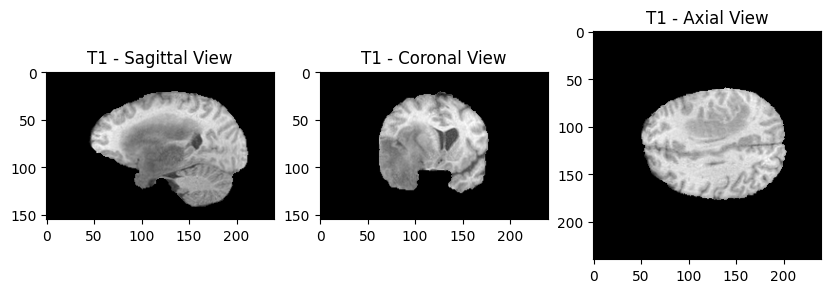

In [ ]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

Most, hogy már tudjuk, miért van három dimenzió, próbáljuk megérteni, hogy miért egy adott szelet megjelenítését választottuk, a `slice_nb` 100-ra állításával.

Ehhez megjelenítjük az összes szeletet:

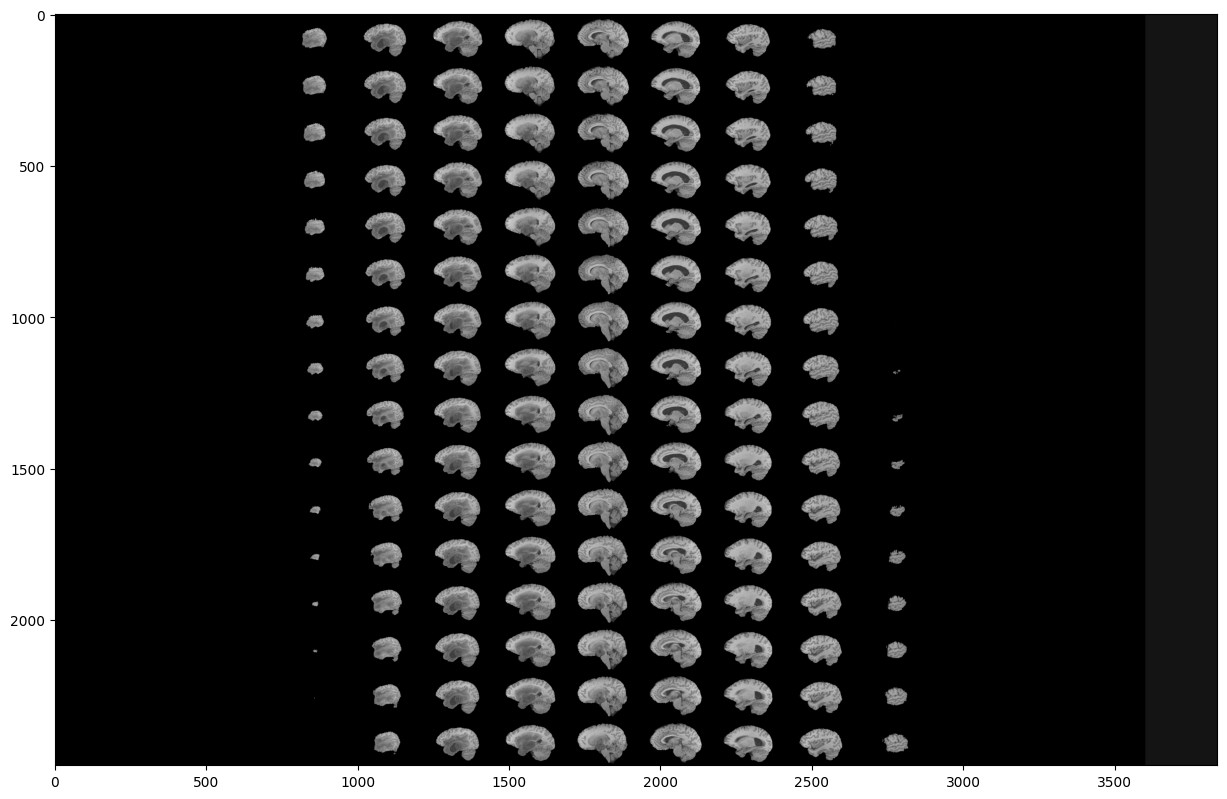

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

Mint látható, **két fekete rész** van jelen a montázsunk mindkét oldalán. Ezek a **fekete részek azonban a sík első és utolsó szeletének** felelnek meg. Ez azt jelenti, hogy a szeletek nagy része nem tartalmaz sok információt. Ez nem meglepő, mivel a szeletek fokozatosan ábrázolják az agyat.

Megfigyelheti, hogy ez az elemzés minden más modalitáson, minden síkban és a szakértők által szegmentált képeken is ugyanez a helyzet. Valóban nem voltak képesek szegmentálni a kevés információt tartalmazó szeleteket.

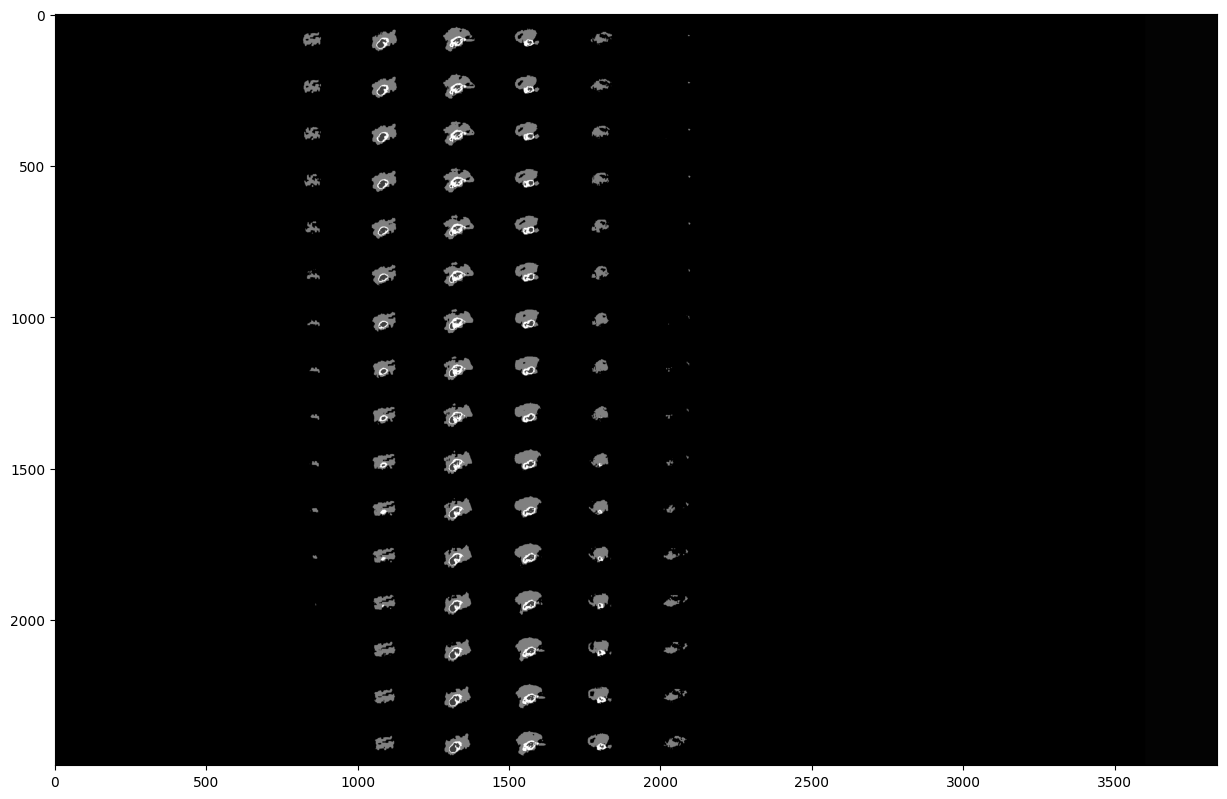

In [ ]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

Ezért ezeket a szeleteket kizárhatjuk az elemzésből, hogy csökkentsük a manipulált képek számát. Valóban láthatjuk, hogy **a (60:135) tartomány sokkal érdekesebb lesz**:

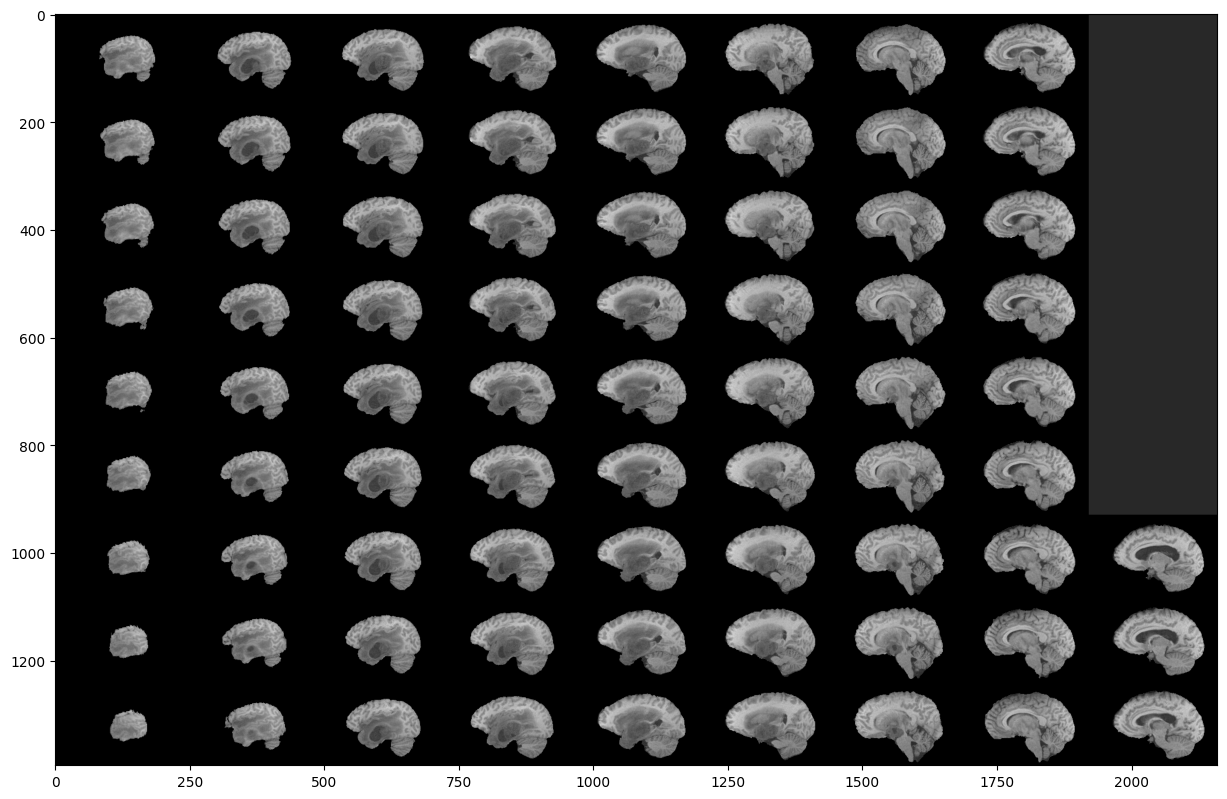

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

Most pedig koncentráljunk a szakértők által megadott **szegmentációkra**. Milyen információkat adnak nekünk?

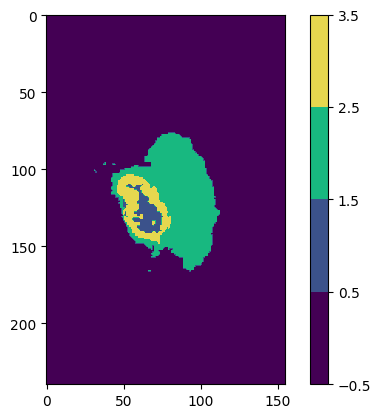

In [ ]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

Függetlenül attól, hogy melyik síkot nézi, észre fogja venni, hogy egyes szeletek több színnel rendelkeznek (itt 4 színnel), ami azt jelenti, hogy a szakértők több értéket rendeltek a szegmentációhoz. Nézzük meg, milyen értékek lehetségesek ebben az adathalmazban:

*(Ennek a cellának a futtatása eltarthat egy ideig, mivel az adathalmazban lévő mind a 369 szegmentáció értékeit megnézzük.)*

In [ ]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


Észrevehetjük, hogy **4 lehetséges érték van a szegmentációs fájlokban**. Ez a 4 érték fogja alkotni a 4 osztályunkat. A következőknek felelnek meg:

- **0** : Not Tumor (NT) which means Healthy Zone or Background --> Nem tumor (NT), ami egészséges zónát vagy hátteret jelent.
- **1** : Necrotic and Non-Enhancing Tumor (NCR + NET) --> Nekrotikus és nem fokozódó tumor (NCR + NET).
- **2** : Peritumoral Edema (ED) --> Peritumorális ödéma (ED)
- **4** : Enhancing Tumor (ET) --> Fokozódó tumor (ET)

Mint látható, a 3. osztály nem létezik. Egyenesen a 4. osztályra megyünk. Ezért ezt a "hibát" módosítjuk, mielőtt elküldjük az adatokat a modellünknek.

A célunk az, hogy az új betegek esetében megjósoljuk és szegmentáljuk mind a 4 osztályt, hogy megtudjuk, van-e agydaganatuk, és mely területek érintettek.

Nézzük most meg ennek a 4 értéknek az eloszlását:

In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


Láthatjuk, hogy az előző szegmentációban sok megjegyzett adatot 0-ra rögzítettek, ami megfelel a háttérnek (haszontalan információ). Megfontolhatjuk a képeink kivágását, hogy eltávolítsuk ennek a haszontalan területnek egy részét, hogy csökkentsük a szegmentálási feladat összetettségét, és így a feldolgozási idő csökkentésével felgyorsítsuk a képzésünket.

Nézzük meg, hogy ez a 4 különböző osztály minek felel meg, az osztályok egyenkénti megjelenítésével:

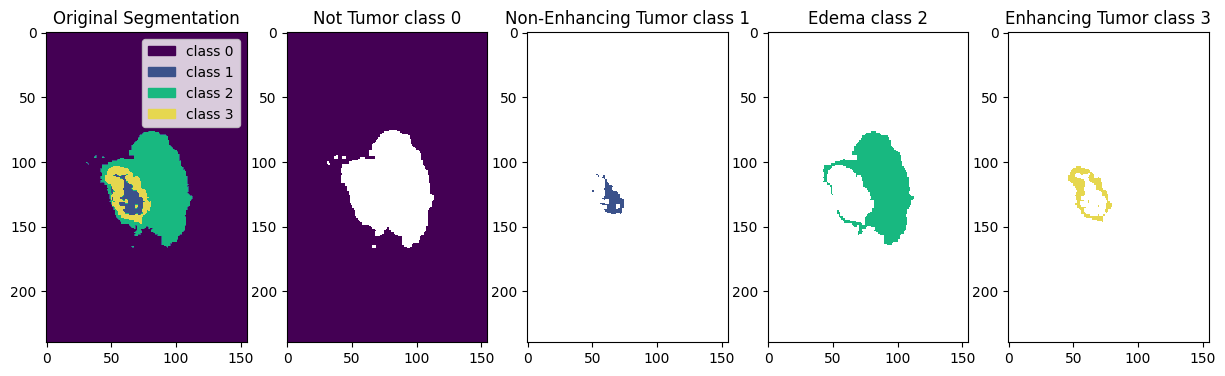

In [ ]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

**Az adatok feltárásának összefoglalása:**

- Minden egyes mintára / betegre vonatkozóan 4 különböző modalitással rendelkezünk (T1, T1CE, T2 és FLAIR), amelyet egy szegmentáció kísér, amely jelzi a tumoros területeket.

- A **T1CE** és **FLAIR** modalitásokat a legérdekesebb megtartani, mivel ez a 2 kiegészítő információt nyújt a beteg agyának anatómiájáról és szöveti kontrasztjáról.

- Mindegyik kép 3D-s, és ezért 3 különböző síkban elemezhető, amelyek 2D-s szeletekből állnak.

- Sok szelet kevés vagy semmilyen információt nem tartalmaz. Ebben a bemutatóban csak a (60:135)** szeletek intervallumát **tartjuk meg. Természetesen szabadon testre szabhatja a kódot, hogy kevesebb vagy több szeletet küldjön a modelljének, de a képzési idő hosszabb lesz.

- Egy szegmentációs kép 1-4 osztályt tartalmaz.

- A 4-es osztályszámot át kell rendelni 3-ra, mivel a 3-as érték hiányzik.

- A 0. osztály (háttér) a felvételek többségében felülreprezentált. A képkivágás azonban fontos információkat távolíthat el. Ebben a bemutatóban nem fogjuk használni, és a képeket úgy hagyjuk, ahogy vannak.

Most, hogy többet tudunk az adatainkról, itt az ideje, hogy előkészítsük a modellünk képzését.

In [ ]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

### 4. lépés - Az adatok előkészítése a képzéshez

#### A - Az adatok 3 csoportra osztása
A mesterséges intelligencia világában egy modell minőségét az határozza meg, hogy **a modell képes-e pontos előrejelzéseket készíteni új, még nem látott adatokra**. Ennek eléréséhez fontos, hogy adatainkat három halmazra osszuk: **Tréning, Validálás és Teszt**.

Emlékeztető ezek hasznosságáról:
- A **Training set** a modell betanítására szolgál. A képzés során a modell ki van téve a képzési adatoknak, és úgy állítja be a paramétereit, hogy minimalizálja a hibát a jóslatai és az alapigazság (szegmentációk) között.

- **Hitelesítési halmaz** a modellünk hiperparamétereinek finomhangolására szolgál, amelyeket a képzés előtt állítunk be, és amelyek meghatározzák a modellünk viselkedését. A cél a különböző hiperparaméterek összehasonlítása és a modellünk számára a legjobb konfiguráció kiválasztása.

- **Tesztkészlet** a modellünk teljesítményének értékelésére szolgál a betanítás után, hogy lássuk, mennyire jól teljesít a modell a nem látott adatokon.

Mint már említettük, a BraTS2020 adathalmaz már 2 mappára van felosztva: egy képzési mappára és egy validálási mappára.

Sajnos a validációs mappa nem tartalmazza a szegmentált adatokat, ezért nem használható. Ezért figyelmen kívül hagyjuk az ebben a mappában lévő mintákat, és létrehozzuk a saját validációs készletünket.

Először keressük le az összes mintát, amelyek a Training mappában vannak:

In [ ]:
# Specify path of our BraTS2020 directory
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


371 fájlt kapunk, míg a braTS-adatkészlet csak 369 mintát tartalmaz. Az ok egyszerű: 2 .csv fájl található a `MICCAI_BraTS2020_TrainingData` könyvtárban, amelyet a `data_path` változó jelez, és ezért hozzáadtuk őket a minták listájához. Ezért el fogjuk őket távolítani:

In [ ]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

Most hozzuk létre a 3 különböző készletet:

In [ ]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


![picture](https://drive.google.com/uc?export=view&id=1nfuTsUfEeuGAg01MqN26MvgGMskDXcq1)

#### B - DataGenerator létrehozása

Ahhoz, hogy egy neurális hálózatot képeken lévő objektumok szegmentálására betanítsunk, a nyers képadatokkal (X) és az alapigazság szerinti szegmentációkkal (y) egyaránt meg kell táplálni. E két adattípus kombinálásával a neurális hálózat megtanulhatja felismerni a tumormintákat, és pontos előrejelzéseket készíthet a beteg felvételének tartalmáról.

Sajnos a modalitási képeink (X) és a szegmentációink (y) nem küldhetők el közvetlenül a mesterséges intelligencia modellnek. Valójában az összes ilyen 3D-s kép betöltése túlterhelné a környezetünk memóriáját, és a rendszer összeomlásához vezetne. Ez shape mismatch hibákhoz is vezetne. Előtte el kell végeznünk némi képelőfeldolgozást, amit egy **Adatgenerátor** segítségével fogunk elvégezni, ahol **minden olyan műveletet** elvégezünk, amit a képek betöltésekor szükségesnek tartunk.

    
Konkrétabban, minden egyes minta esetében:

- Megkeressük a modalitások útvonalait (T1CE és FLAIR, mivel ez a kettő egymást kiegészítő információt nyújt az agy anatómiájáról és szöveti kontrasztjáról).

- Megkeressük az alapigazság (eredeti szegmentáció) útvonalát.

- Módalitások és szegmentáció betöltése

- Hozzon létre egy X tömböt, amely tartalmazza a 2 modalitás összes kiválasztott szeletét (60-135).

- Hozzon létre egy y tömböt, amely a szegmentáció összes kiválasztott szeletét tartalmazza.

- A maszktömb minden 4-hez rendelje hozzá a 3 értéket (a korábban ismertetett 3 hiányzó eset korrigálása érdekében).


Ezen előfeldolgozási lépéseken kívül:

- **A tengelysíkban dolgozunk**: Mivel a képek ebben a síkban négyzet alakúak (240x240). De mivel egy sor szeletet fogunk manipulálni, az előrejelzéseket a 3 síkban fogjuk tudni megjeleníteni, így ez nem igazán van hatással.

- ** Alkalmazzunk egy One-Hot kódolót az y tömbre**: Mivel a célunk a különböző osztályokként (0-tól 3-ig) reprezentált régiók szegmentálása, One-Hot Encoding-ot kell használnunk, hogy a kategorikus változóinkat (osztályokat) numerikus reprezentációvá alakítsuk, amelyet a neurális hálózatunk használhat (mivel matematikai egyenleteken alapulnak). Matematikai szempontból ugyanis az y tömb változatlan elküldése azt jelentené, hogy egyes osztályok jobbak, mint mások, miközben nincs közöttük felsőbbrendűségi kapcsolat. Például az 1. osztály alsóbbrendű a 4. osztálynál, mivel 1 < 4. Az egy-hat kódoló lehetővé teszi számunkra, hogy csak a 0-t és az 1-et manipuláljuk. Íme, miből áll ez, egy szeletre:


![picture](https://drive.google.com/uc?export=view&id=1UYlBryJuqSfVJ2fud7LMlupAFtJwO8HR)

- **Átméretezzen képeink minden szeletét (240x240) alakzatra (128,128)**: A szeleteket (240x240)-ről (128x128) méretre kell átméretezni, mivel olyan képformákra van szükségünk, amelyek kettő hatványa (2<) sup>n</sup>, ahol n egész szám). Ez annak köszönhető, hogy a konvolúciós neurális hálózatunkban (CNN) pooling layereket (MaxPooling2D) fogunk használni, amelyek 2-vel csökkentik a térbeli felbontást.

Elgondolkodhat azon, hogy miért nem méreteztük át a képeket egy (256, 256) alakzatban, amely szintén 2 hatványa, és közelebb van a 240-hez, mint a 128-hoz.

Ez a választás több tényezőtől függ, például a modell összetettségétől, a betanítási adatok mennyiségétől, a rendelkezésre álló számítási erőforrásoktól, valamint a számítási hatékonyság és az információmegőrzés közötti kívánt egyensúlytól.

Valójában a képek (256, 256) méretre való átméretezése több információt őrizhet meg, mint a (128, 128) méretre való átméretezés, ami jobb teljesítményt eredményezhet. Ez a nagyobb méret azonban azt is jelenti, hogy a modellnek több paramétere lesz, ami növelheti az edzési időt és a memóriaigényt, ezért a (128, 128) alakot választjuk.

*Természetesen szabadon betaníthatja modelljét (256, 256) képekkel, de ne feledje, hogy módosítania kell U-Net architektúráját.*

In [ ]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1_path = sample_path + '_t1.nii'
            t2_path = sample_path + '_t2.nii'
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'


            # Extract the data from these paths
            #t1 = nib.load(t1_path).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()


            for j in range(VOLUME_SLICES):
                 #X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 #X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y #X/np.max(X) ez nem feltetlenul kell

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

**Az előfeldolgozási lépések összefoglalásaként**:
- Adatgenerátort használunk, hogy adatainkat feldolgozzuk és neurális hálózatunkba küldjük (hiszen nem tárolható egyszerre minden képünk a memóriában).
- Minden korszakhoz (a teljes képzési adatkészlet egyszeri áthaladása egy neurális hálózaton keresztül) a modell 250 mintát kap (a tanítási adatkészletünkben szereplőket).
- Minden mintához a modellnek 150 szeletet kell elemeznie (mivel két modalitás van, és mindkettőhöz 75 kiválasztott szelet), amelyeket (128, 128) alakban, a (128, 128 X tömbjeként) kapunk. , 75, 2) alakzat. Ez a tömb a páciens alapigazság-szegmentációjával lesz ellátva, amely One-Hot kódolású lesz, és ezután (75, 128, 128, 4) alakú lesz.

### 5. lépés – Határozza meg a modellt

Most, hogy ismételhetjük adatainkat, meghatározhatjuk szegmentációs modellünket.

#### A - U-Net

Az [U-Net architektúrát](https://en.wikipedia.org/wiki/U-Net#/media/File:Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png). This [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) az orvosbiológiai képek szegmentálására tervezték, és különösen jól használható olyan szegmentációs feladatokhoz, ahol az érdeklődésre számot tartó régiók kicsik és összetett formájúak (például daganatok az MRI-vizsgálatokban).


Mivel a BraTS2020 adatkészlet 3D képekből áll, ahol mindegyik több 2D szeletből áll három merőleges síkban, két lehetőségünk van. Használhatunk 2D U-Net vagy 3D U-Net.

Elméletileg a 3D U-Net jobban megfelel a mi esetünknek. Valójában a 3D U-Net képes kiaknázni a képek 3D-s térbeli kontextusát, ami azt jelenti, hogy csökkentheti a hamis pozitív és hamis negatívumok kockázatát, amelyek az egyes 2D szeletek részleges vagy hiányos információi miatt fordulhatnak elő.

A 2D U-Net azonban gyorsabb és kevesebb memóriát igényel, mint a 3D U-Net, ami előnyt jelenthet nagy adatkészletekkel vagy korlátozott számítási erőforrásokkal végzett munka során.

A gyakorlatban gyakran hasznos kipróbálni a 2D és 3D U-Net architektúrákat is, és összehasonlítani a teljesítményüket az adott szegmentálási feladatnál.

Ebben az oktatóanyagban a 2D neurális hálózat megvalósítását választjuk:

In [ ]:
def encoderblok(filters1,inputs,activations):

    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (inputs)
    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (c11)


    c11 = Dropout(0.2) (c11)

    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (c11)
    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (c11)

    p1 = MaxPooling2D(pool_size=(2, 2)) (c11)
    return c11,p1

In [ ]:
def decoder(filters1,c77,c22,activations):
    u8 = Conv2D(filters1, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = 2)(c77))
    u8 = concatenate([u8, c22])

    c88 = Conv2D(filters1, 3, activation=activations, padding='same',) (u8)
    c88 = Conv2D(filters1, 3, activation=activations, padding='same',) (c88)

    c88 = Dropout(0.2) (c88)
    c88 = Conv2D(filters1, 3, activation=activations, padding='same') (c88)
    c88 = Conv2D(filters1, 3, activation=activations, padding='same') (c88)

    return c88

In [ ]:
def bridge(filters1,inputs,activations):

    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (inputs)
    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (c11)

    c11 = Dropout(0.2) (c11)

    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (c11)
    c11 = Conv2D(filters1, 3, activation=activations, padding='same',) (c11)
    return c11

#### B - Veszteségfüggvény

A CNN betanításakor fontos olyan veszteségfüggvény kiválasztása, amely pontosan tükrözi a hálózat teljesítményét. Valójában ez a funkció lehetővé teszi az előrejelzett pixelek összehasonlítását az alapigazság képpontjaival minden egyes páciens esetében. Minden korszakban a cél az, hogy modellünk súlyait frissítsük oly módon, hogy ez a veszteségfüggvény minimális legyen, és ezáltal javítsa az előrejelzések pontosságát.

A többosztályos osztályozási problémákra gyakran használt veszteségfüggvény a **categorical cross-entropy**, amely az egyes pixelek előrejelzett valószínűségi eloszlása és az egyforró kódolású alapigazság valós értéke közötti különbséget méri. Vegye figyelembe, hogy a szegmentációs modellek néha a **dice loss** funkciót is használják.

#### C - Kimenet aktiválási funkció

Ahhoz, hogy ezt a valószínűségi eloszlást megkapjuk az egyes pixelek különböző osztályai között, egy **softmax** aktiválási függvényt alkalmazunk neurális hálózatunk kimeneti rétegére.

Ez azt jelenti, hogy edzés közben a CNN-ünk úgy állítja be a súlyait, hogy minimalizálja a veszteségfüggvényünket, amely összehasonlítja a softmax függvény által adott előrejelzett valószínűségeket az alapigazság-szegmentációval.

#### E – Építsd meg a modellt

In [ ]:
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
epochs=10
def build_model():
    # Define input data shape
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

    # Build and compile the model
    filters= 80
    activations = "relu"
    s1,p1 = encoderblok(filters,input_layer,activations)
    s2,p2 = encoderblok(filters//2,p1,activations)
    s3,p3 = encoderblok(filters//4,p2,activations)
    s4,p4 = encoderblok(filters//8,p3,activations)
    b = bridge(filters//16,p4,activations)
    d1 = decoder(filters//8,b,s4,activations)
    d2 = decoder(filters//4,d1,s3,activations)
    d3 = decoder(filters//2,d2,s2,activations)
    d4 = decoder(filters,d3,s1,activations)
    outputs1 = Conv2D(4, 1, activation="softmax",padding="same") (d4)

    model = Model(inputs=input_layer, outputs=[outputs1])
    model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001, weight_decay=0.001 / (epochs * 0.5)),
              metrics = ['accuracy'])
    gc.collect()
    return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 80)         1520      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 80)         57680     ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 80)         0         ['conv2d_1[0][0]']            
                                                                                              

#### F - Visszahívások beállítása (Set up callbacks)

A visszahívások olyan funkciók, amelyek a betanítási folyamat során végrehajthatók.

Három visszahívást fogunk használni:

- **ReduceLROnPlateau**: Ez a visszahívás csökkenti a tanulási sebességet, ha a metrika javulása leállt (itt az érvényesítési veszteség). A tanulási sebesség 0,2-szeresére csökken, a türelmet 2 korszakra, a minimális tanulási sebességet pedig 0,000001-re állítjuk.

- **ModelCheckpoint - Modellellenőrzési pont**: A legjobb modellsúlyokat menti el (olyan modell, amely a legalacsonyabb érvényesítési veszteséget érte el a különböző korszakok során). A modell mentése lehetővé teszi számunkra, hogy később újra felhasználjuk vagy megosszuk, anélkül, hogy a semmiből újra kellene tanítanunk. Ezzel időt és erőforrásokat takaríthatunk meg!

- **CSVLogger**: Adjon hozzá mérőszámokat egy *training.log* nevű CSV-fájlhoz (az `append` paraméter értéke `False`, így a fájl felülíródik, ha már létezik).

In [ ]:
gc.collect()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5', save_best_only=True,verbose=1)
]


### 6. lépés – Betanítsa és mentse a modellt

Most már készen állunk a mély neurális hálózatunk képzésére a Keras *.fit()* metódusával. A 3 visszahívásunkat átadjuk a metódusnak, így azok a 35 epocháig tartó betanítási folyamat során végrehajthatók.

In [ ]:
gc.collect()

History = model.fit(training_generator,validation_data=valid_generator, epochs=epochs, steps_per_epoch=len(samples_train), callbacks=callbacks, verbose=1,batch_size=1)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9780
Epoch 1: val_loss improved from inf to 0.08620, saving model to model_.01-0.086195.m5
250/250 [==============================] - 407s 1s/step - loss: 0.1198 - accuracy: 0.9780 - val_loss: 0.0862 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9815
Epoch 2: val_loss improved from 0.08620 to 0.07698, saving model to model_.02-0.076978.m5
250/250 [==============================] - 371s 1s/step - loss: 0.0803 - accuracy: 0.9815 - val_loss: 0.0770 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9815
Epoch 3: val_loss improved from 0.07698 to 0.07495, saving model to model_.03-0.074946.m5
250/250 [==============================] - 370s 1s/step - loss: 0.0783 - accuracy: 0.9815 - val_loss: 0.0749 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 4/10


### Töltse le a betanított súlyokat a jövőbeni következtetések érdekében

Visszahívásainknak köszönhetően súlyfájlok generálódnak, és hozzáadódnak a notebook környezetéhez az edzés során.

Ha nem akarja elveszíteni az edzést, vagy szeretné újra felhasználni a modellt a jövőbeni következtetésekhez, **megkérem Önt, hogy töltse le súlyait** a Fájlböngészőből, a notebook felületének bal oldalán. **Győződjön meg arról, hogy egy korszak két fájlját (`m5.data` és `m5.index` fájl) töltse le**, hogy újra felhasználhassa ezeket a súlyokat.

Természetesen jogos megkérdezni, hogy **mely fájlokat kell letölteni? Melyek tartalmazzák a legjobb súlyokat?** A kérdések megválaszolásához elemezzük az egyes korszakokra kapott pontszámokat.

### Metrikák elemzése

Most, hogy a képzés befejeződött, ideje egy pillantást vetni a CSVLogger visszahívására, hogy jobban megértsük a képzési folyamatot és modellünk teljesítményét.

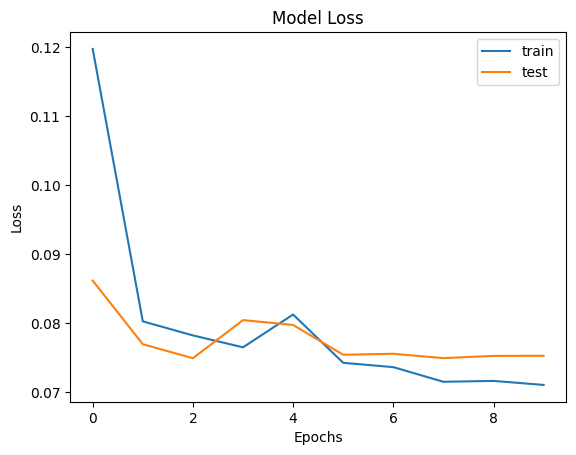

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

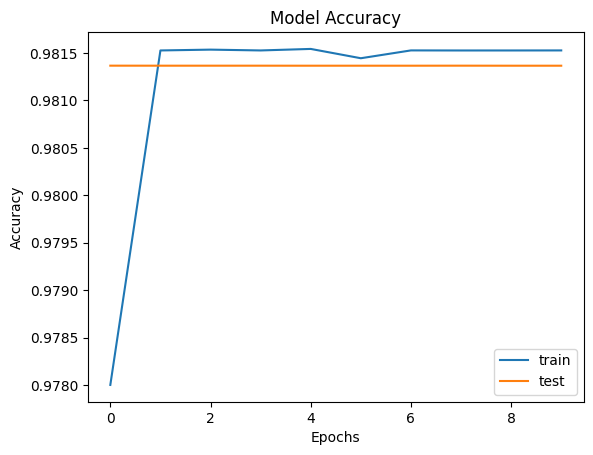

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

A pontossági grafikonon azt láthatjuk, hogy mind a betanítási pontosság, mind az érvényesítési pontosság korszakonként növekszik, és elér egy platót. Ez azt jelzi, hogy a modell tanul az adatokból, és jól általánosítja az újat.
Nem úgy tűnik, hogy túlszereléssel nézünk szembe, mivel mindkét mutató javul.

Ekkor láthatjuk, hogy modelljeink egyértelműen tanulnak a betanítási adatokból, mivel a második grafikonon mindkét veszteség idővel csökken. Azt is észrevesszük, hogy modellünk legjobb verzióját a 26. korszak környékén érjük el (ezt láthatjuk az edzésnaplókban is). Ezt a következtetést erősíti meg a következő grafikon, ahol mindkét dice együttható növekszik a korszakok során.

#Modell mentése

In [ ]:
import pickle
pickle.dump(model, open("/content/drive/My Drive/Colab Notebooks/BraTS2020 Dataset/UnetTrainedModel.keras", 'wb'))

#Vagy
# model.save('my_model.keras')

#Tesztelés
### Egyéb mutatók:

Szintén fontos a modell teljesítményének nyomon követése értékelési mérőszámok segítségével.

Természetesen a **pontosság**-t fogjuk használni, ami nagyon népszerű mértékegység. Ez a mérőszám azonban félrevezető lehet, ha olyan kiegyensúlyozatlan adatkészletekkel dolgozik, mint a BraTS2020, ahol a Háttér osztály felülreprezentált. A probléma megoldásához más mérőszámokat fogunk használni, például a **egyesülés (IoU) metszéspontját, a kocka együtthatót, a pontosságot, az érzékenységet és a specifitást**.

- **Accuracy - Pontosság**: A helyesen osztályozott képpontok teljes arányát méri, beleértve a pozitív és negatív képpontokat is.

- **Sensitivity - Érzékenység** (recall or true positive rate - visszahívás vagy valódi pozitív arány): A helyesen pozitívnak jósolt pozitív alapigazság-pixelek arányát méri.

- **Precision - Precíziós** (positive predictive value - pozitív prediktív érték): A ténylegesen pozitív előrejelzett pozitív képpontok arányát méri.

- **Specificity - Specifikusság** (true negative rate - valós negatív arány): A negatív alapigazság-pixelek arányát méri, amelyeket helyesen negatívnak jósoltak meg.

In [ ]:
y_pred = model.predict(test_generator)
#vegul pedig teljesitmeny analitist végzek
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

45/45 [==============================] - 14s 316ms/step


In [ ]:
# A predikciók maximalizálása a valószínűségi mátrixhoz
y_pred_max = np.argmax(y_pred, axis=-1)

In [ ]:
# Valós címkék a teszt adatokon
y_true = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

In [ ]:
y_true_max = np.argmax(y_true, axis=-1)
gc.collect()

0

In [ ]:
# Konfúziós mátrix létrehozása
conf_matrix = confusion_matrix(y_true_max.flatten(), y_pred_max.flatten())

# Konfúziós mátrix kiíratása
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[54008076        0        0        0]
 [  295570        0        0        0]
 [  730502        0        0        0]
 [  261852        0        0        0]]


In [ ]:
def perf_measure(index, conf_matrix):
    # CM = confusion_matrix(y_test, y_pred)
    CM = conf_matrix

    for i in range(index, 4):
        #4 osztaly a ciklus alapjan
        print("osztaly: " ,i+1)
        TP = CM[i][i]
        FP = CM[i,:].sum() - TP
        FN = CM[:,i].sum() - TP
        TN = CM[:,:].sum() - TP - FP - FN

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)

        # Specificity or true negative rate
        TNR = TN/(TN+FP)

        # PPV positive predictive value
        PPV = TP/(TP+FP)

        # NPV negative predictive value
        NPV = TN/(TN+FN)

        #Accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        #Dice score
        DS = (2*TP)/((2*TP)+FP+FN)

        print("True positive :", TP)
        print("True negative :", TN)
        print("False positive :", FP)
        print("False negative :", FN, '\n')

        print("True positive rate :", TPR)
        print("True negative rate :", TNR)
        print("Positive predictive value :", PPV)
        print("Negative predictive value :", NPV)
        print("Accuracy :", ACC)
        print("Dice score :", DS, '\n')

In [ ]:
perf_measure(0, conf_matrix)

osztaly:  1
True positive : 54008076
True negative : 0
False positive : 0
False negative : 1287924 

True positive rate : 0.9767085503472223
True negative rate : nan
Positive predictive value : 1.0
Negative predictive value : 0.0
Accuracy : 0.9767085503472223
Dice score : 0.9882170542295239 

osztaly:  2
True positive : 0
True negative : 55000430
False positive : 295570
False negative : 0 

True positive rate : nan
True negative rate : 0.9946547670717593
Positive predictive value : 0.0
Negative predictive value : 1.0
Accuracy : 0.9946547670717593
Dice score : 0.0 

osztaly:  3
True positive : 0
True negative : 54565498
False positive : 730502
False negative : 0 

True positive rate : nan
True negative rate : 0.9867892433449074
Positive predictive value : 0.0
Negative predictive value : 1.0
Accuracy : 0.9867892433449074
Dice score : 0.0 

osztaly:  4
True positive : 0
True negative : 55034148
False positive : 261852
False negative : 0 

True positive rate : nan
True negative rate : 0.99

<ipython-input-51-3b10579a36a7>:17: RuntimeWarning: invalid value encountered in scalar divide
  TNR = TN/(TN+FP)
<ipython-input-51-3b10579a36a7>:14: RuntimeWarning: invalid value encountered in scalar divide
  TPR = TP/(TP+FN)


Most peddig nézzük meg, hogy hogyan teljesítettek az osztályok az agyi szövet 0 osztály nélkül:

In [ ]:
perf_measure(1, conf_matrix)

osztaly:  2
True positive : 0
True negative : 55000430
False positive : 295570
False negative : 0 

True positive rate : nan
True negative rate : 0.9946547670717593
Positive predictive value : 0.0
Negative predictive value : 1.0
Accuracy : 0.9946547670717593
Dice score : 0.0 

osztaly:  3
True positive : 0
True negative : 54565498
False positive : 730502
False negative : 0 

True positive rate : nan
True negative rate : 0.9867892433449074
Positive predictive value : 0.0
Negative predictive value : 1.0
Accuracy : 0.9867892433449074
Dice score : 0.0 

osztaly:  4
True positive : 0
True negative : 55034148
False positive : 261852
False negative : 0 

True positive rate : nan
True negative rate : 0.9952645399305555
Positive predictive value : 0.0
Negative predictive value : 1.0
Accuracy : 0.9952645399305555
Dice score : 0.0 



<ipython-input-51-3b10579a36a7>:14: RuntimeWarning: invalid value encountered in scalar divide
  TPR = TP/(TP+FN)


### 7. lépés – A daganat szegmentációjának előrejelzése

Most, hogy modellünket betanították, itt az ideje, hogy felhasználjuk a tesztadatkészletünk szegmentációinak előrejelzésére!

Általában két fő lehetőségünk van:

- Használja a legjobb modell súlyait (a 26-os korszaktól)
- Használja a végső modell súlyait

Valójában a végső modell súlyozásának használata nem feltétlenül jelenti azt, hogy új, nem látott adatokon kapjuk a legjobb teljesítményeket, előrejelzéseket.

A mi esetünkben nincs érdemi különbség a két lehetőség között, így a választás nem igazán számít.

De egy másik esetben a modell egy adott verziója érdekelheti. A következő kóddal töltheti be:

Most készítsünk egy függvényt, amely lehetővé teszi, hogy előre jelezzük egy páciens szegmentációját a tesztadatkészletben. Axiális síkban fogok kijelzőt választani, de teljesen választhatunk egy másik síkot is.

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

A következőben a predict_segmentation() függvényt fogjuk meghívni, hogy előre jelezzük egy páciens szegmentációját, ábrázoljuk és összehasonlítjuk az eredetivel.

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

#### Véletlenszerű előrejelzések és összehasonlítás az eredetivel (Ground truth - alap igazság)

3/3 [==============================] - 6s 1s/step
Patient number:  BraTS20_Training_308


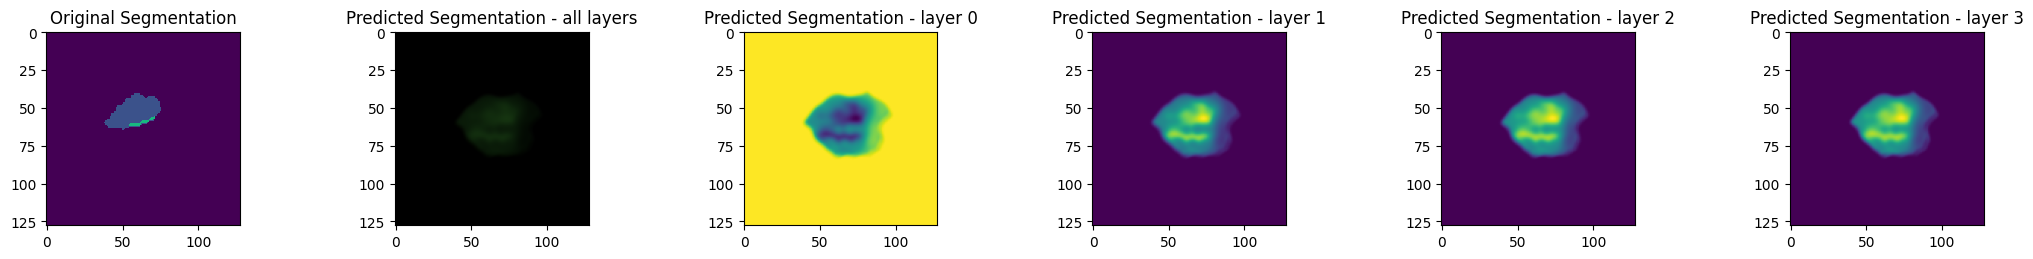

In [ ]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 [==============================] - 0s 165ms/step
Patient number:  BraTS20_Training_238


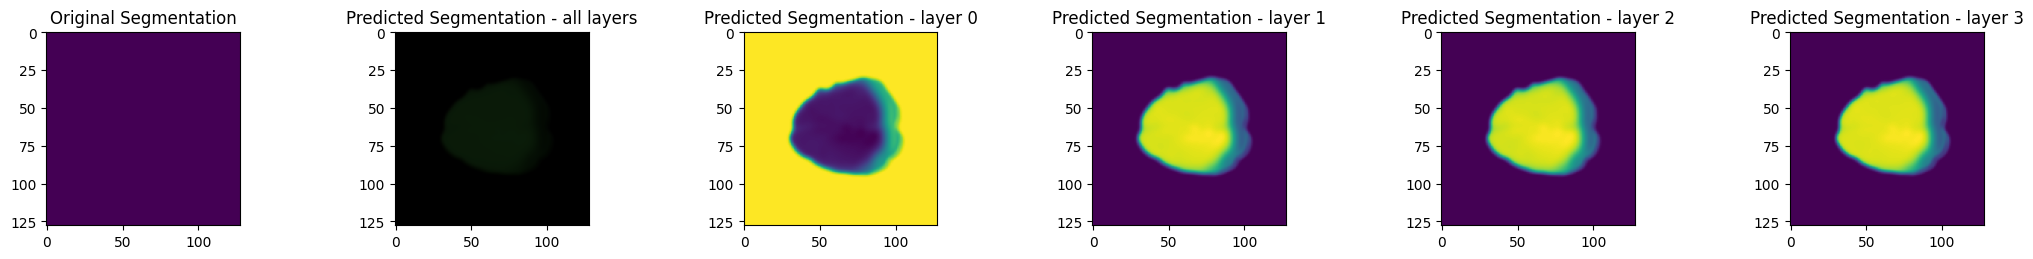

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

3/3 [==============================] - 0s 111ms/step
Patient number:  BraTS20_Training_110


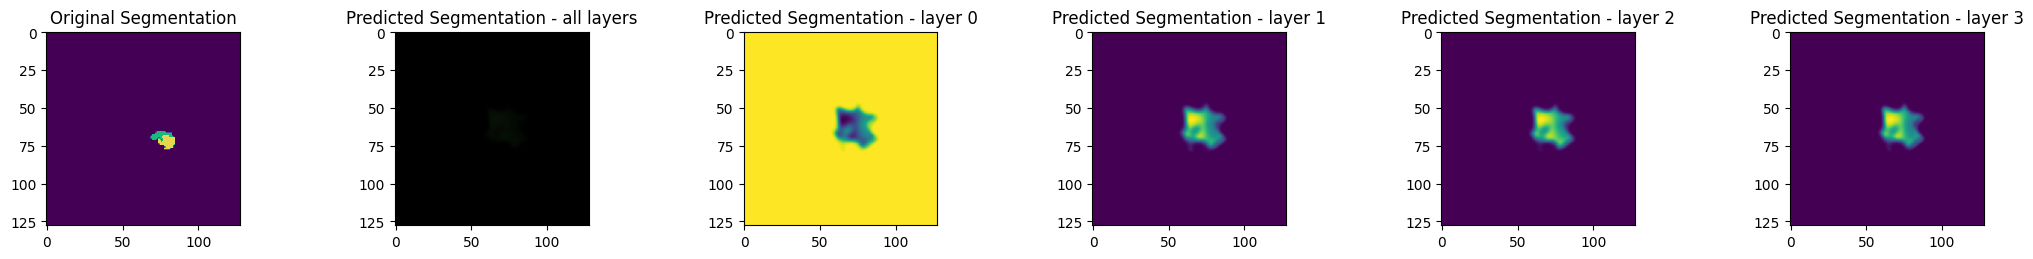

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 112ms/step
Patient number:  BraTS20_Training_308


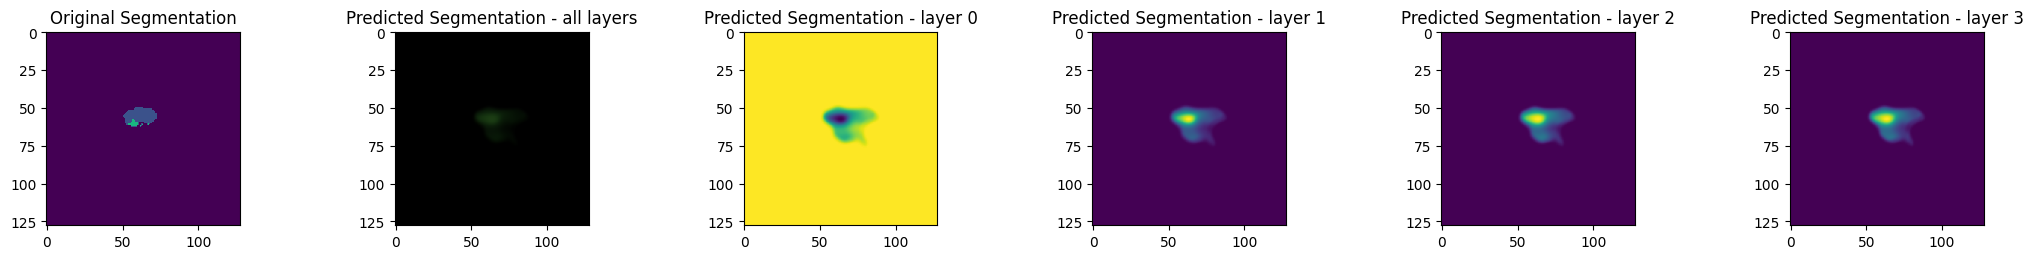

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

3/3 [==============================] - 0s 111ms/step
Patient number:  BraTS20_Training_238


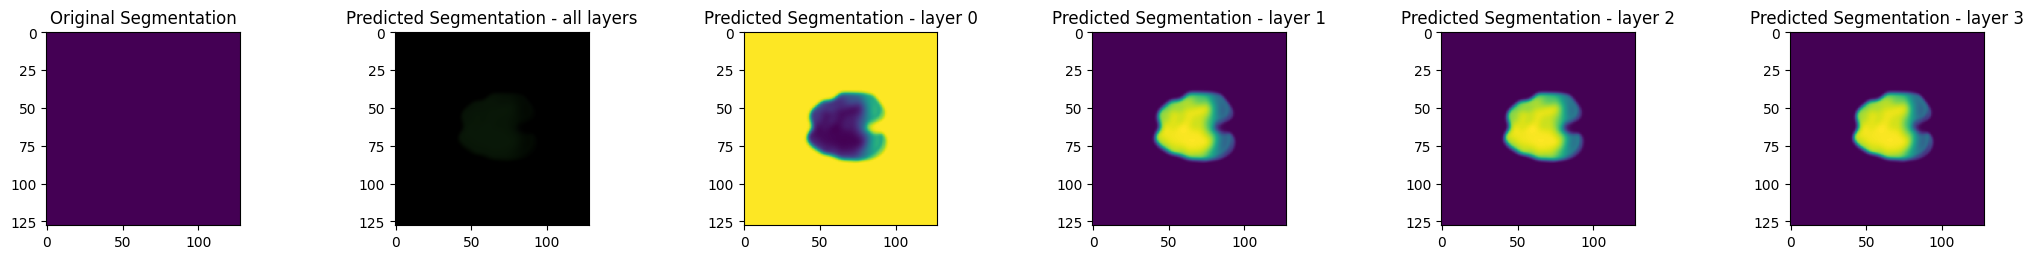

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

Amint látható, az előre jelzett szegmentálások meglehetősen pontosak.

Sajnos van néhány **false positives**, ami azt jelenti, hogy akkor észlelünk daganatot, amikor eredetileg nincs jelen *(vö. 3. diagram, 266. beteg, 70. szelet)*.

Egy olyan területen, mint az orvosi elemzés, ez egyfajta kínos. Képzeld el, hogy egy mesterséges intelligencia azt mondja neked, hogy daganatod van, pedig egészséges vagy. Ez szükségtelen kezelésekhez vezethet, amelyek negatív hatással lehetnek egészségére és életminőségére.

Íme néhány módszer a probléma megoldására:

- **Neural Network - Neurális hálózat**: Esetleg módosítsa a modell architektúráját, próbáljon ki egy 3D CNN-t.

- **Dataset - Adatkészlet**: A modell betanítása egy nagyobb adatkészletre

- **Modalities & slices - Modalitások és szeletek**: Lehet, hogy az általunk használtaktól eltérő vagy eltérő módozatokat válasszon. Válasszon több szeletet vagy egy másik szelettartományt a modellképzéshez.

- **Post-processing techniques - Utófeldolgozási technikák**: Argmax dekódolás, Thresholding, Morfológiai műveletek, mint az erózió / dilatáció az előre jelzett szegmentációk finomításához. Valójában észrevesszük, hogy a hibák nagyon kevéssé láthatók. Az utófeldolgozás tehát kiküszöbölheti őket.

#### Utófeldolgozás

Az argmax dekódolási technikát fogjuk használni. Ez a folyamat abból áll, hogy az argmax függvényt alkalmazzuk, hogy minden pixelhez egyetlen címkét kapjunk, amely a legnagyobb valószínűséggel rendelkező osztálynak felel meg. Valójában a pixeleink jelenleg minden osztályhoz rendelkeznek valószínűségi értékkel, mivel ezeket a softmax aktiválási függvény segítségével kaptuk.

Ez azt is lehetővé teszi számunkra, hogy az eredeti szegmentálás és az előrejelzés között ugyanazok a színek jelenjenek meg, amelyek könnyebben összehasonlíthatók, mint a fentiek.

Ezeket a technikákat ugyanazokon a betegeken hajtjuk végre, mint korábban. Ez lehetővé teszi, hogy megnézze, hogy a helyes jóslatok megmaradnak-e, és ha a hamis pozitív előrejelzéseket eltávolítják!

In [ ]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):

    # Get path of this patient
    sample_path = os.path.join(data_path, sample, sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3

    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan

    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4]

    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 0s 169ms/step
Patient number:  BraTS20_Training_266


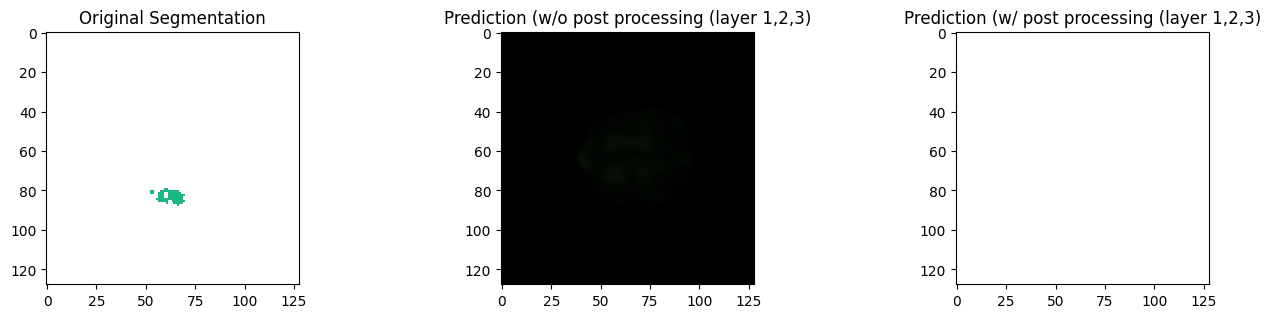

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 111ms/step
Patient number:  BraTS20_Training_051


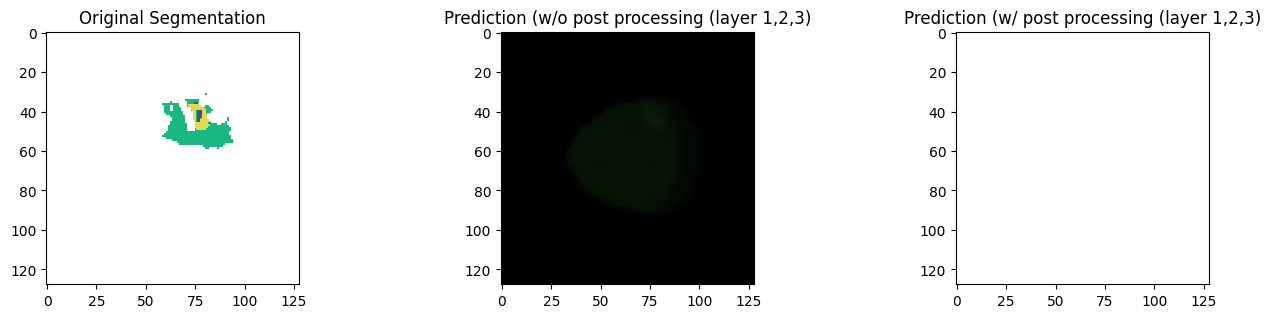

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 114ms/step
Patient number:  BraTS20_Training_266


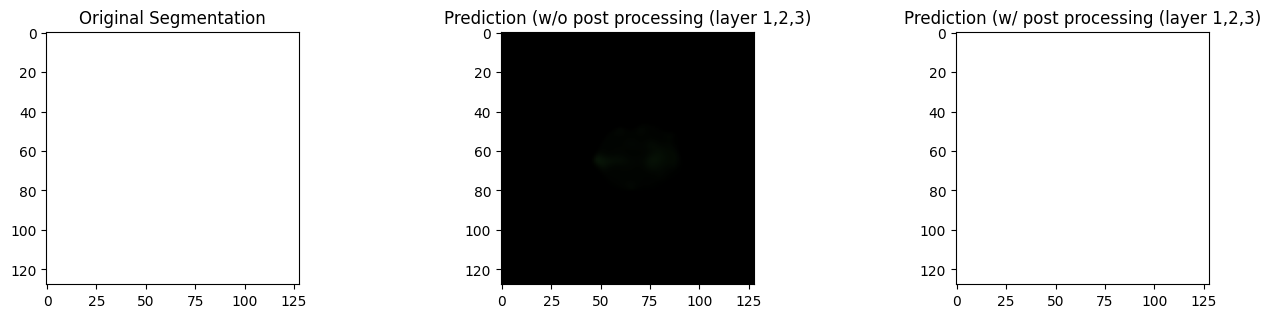

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 111ms/step
Patient number:  BraTS20_Training_051


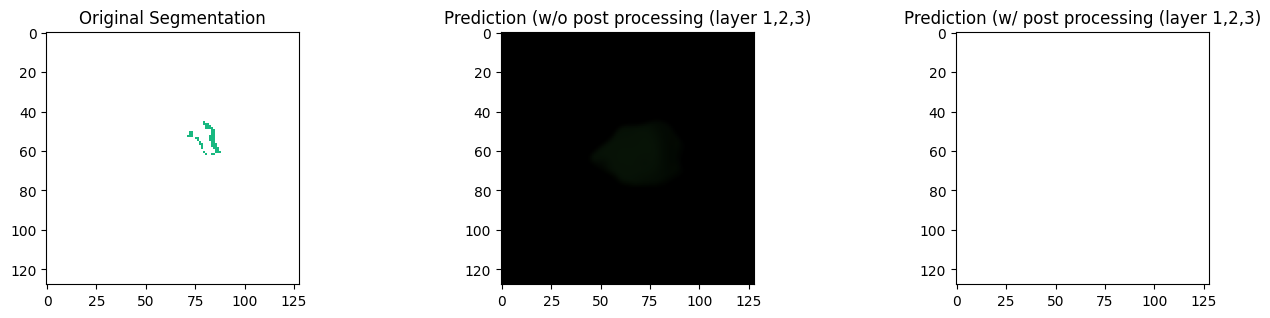

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 112ms/step
Patient number:  BraTS20_Training_274


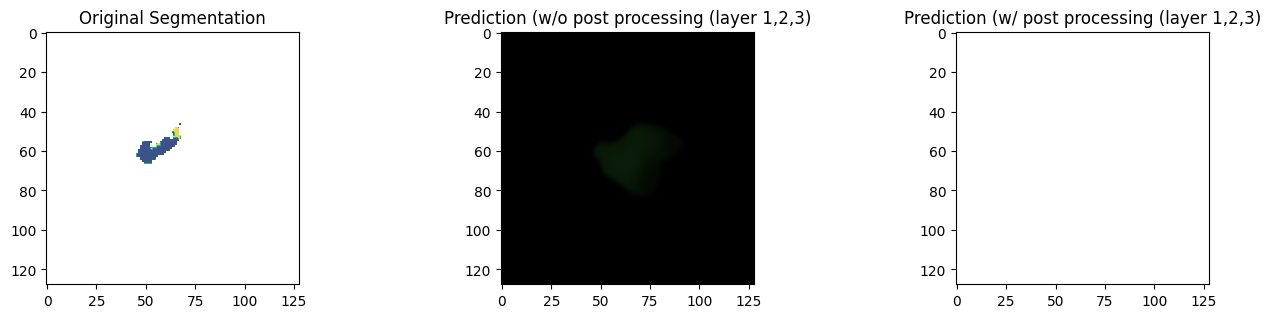

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

Úgy tűnik, az argmax dekódolási technika elég jól működik! Valóban, a hamis pozitív *(vö. 3. diagram, páciens_266, 70. szelet)* utófeldolgozással eltávolítva, a többi előrejelzés pedig jól megmaradt!

### 8. lépés – A modell értékelése
Befejezésül hívjuk meg az evaluate() függvényt, amellyel kiértékelhetjük modellünk teljesítményét a tesztadatkészletünkön.

In [ ]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 17s 365ms/step - loss: 0.0818 - accuracy: 0.9767

Model evaluation on the test set:
Loss : 0.0818
Accuracy : 0.9767


Megállapíthatjuk, hogy a modell nagyon jól teljesített a tesztadatkészleten, **low test loss (0.0206)**, **helyes dice együtthatót (0,6008) ért el egy képszegmentációs feladathoz**, és **jó pontszámot ért el egyéb mérőszámok**, amelyek azt jelzik, hogy a modell jó általánosítási teljesítményt nyújt a nem látott adatokon.

## Következtetés

Remélem tetszett ez az oktatóanyag!

Most már kényelmesebb a képszegmentálás!

Ne feledje, hogy még ha eredményeink pontosnak tűnnek is, van néhány téves pozitív előrejelzésünk. Egy olyan területen, mint az orvosi képalkotás, kulcsfontosságú a valódi pozitív és a hamis pozitívumok közötti egyensúly értékelése, valamint a mesterséges megközelítés kockázatainak és előnyeinek felmérése.



#A labor feladat:


1.   Értelmezd a kódot
2.   Érj el jobb eredményt a jelenlegi esettől, vagyis készíts jobb modellt mint ami van. Ha egy kicsivel is jobb nyugodtan megállhatsz.

Előre jelezem a kód lefutási ideje megközelítőleg 3-4 óra. Szóval csak óvatosan, mivel sokideig tart a tanulás.


